In [1]:
import datetime as dt
from urllib.request import urlopen  
import bs4
import re
import pandas as pd

In [2]:
'''
한국거래소 시가총액 상위 10종목 (2018년4월15일 기준)
005930	삼성전자
000660	SK하이닉스
068270	셀트리온
207940	삼성바이오로직스
005380	현대차
005490	POSCO
051910	LG화학
028260	삼성물산
035420	NAVER
012330	현대모비스
'''
k10_component = ['005930', '000660', '068270', '207940', '005380',\
                 '005490', '051910', '028260', '035420', '012330']

In [3]:
# 구성종목 기본정보
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    
    tmp = re.split('/', tmp)

    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)

    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [4]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
    stock_info(stock_cd)

In [5]:
# 과거 시세만 반영
tmp = {'Outstanding' : k10_outstanding,\
       'Floating' : k10_floating,\
       'Name' : k10_name}
k10_info = pd.DataFrame(tmp)
k10_info

,Floating,Name,Outstanding
000660,76.91,SK하이닉스,728002365
005380,65.44,현대차,220276479
005490,79.26,POSCO,87186835
005930,72.78,삼성전자,6419324700
012330,67.12,현대모비스,97343863
028260,48.05,삼성물산,189690043
035420,77.87,NAVER,32962679
051910,64.28,LG화학,70592343
068270,63.33,셀트리온,125395903
207940,21.78,삼성바이오로직스,66165000


In [6]:
def date_format(d):

    d = str(d)
    d = d.replace('/', '-')
    d = d.replace('.', '-')

    yyyy = int(d.split('-')[0])
    if yyyy < 50:
        yyyy = yyyy + 2000
    elif yyyy >=50 and yyyy < 100:
        yyyy = yyyy + 1900
    mm = int(d.split('-')[1])
    dd = int(d.split('-')[2])

    return dt.date(yyyy, mm, dd)

In [7]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')   # 날짜 수집   
    prices = source.find_all('td', class_='num')   # 종가 수집
    
    for n in range(len(dates)):
    
        if len(dates) > 0:
            
            # 날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                              
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
        
    # 다음 페이지 호출
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [8]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_prices = historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [9]:
k10_historical_price = pd.DataFrame(k10_historical_prices)

In [10]:
k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='bfill')
k10_historical_price.head(3)

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2017-01-02,45800.0,150000.0,260500.0,1805000.0,271500.0,125500.0,777000.0,253000.0,108200.0,156500.0
2017-01-03,47250.0,153000.0,256000.0,1824000.0,275500.0,129000.0,767000.0,262000.0,106600.0,158000.0
2017-01-04,46500.0,154000.0,254500.0,1808000.0,276000.0,129000.0,810000.0,268500.0,106100.0,154500.0


In [11]:
k10_historical_price['005930'] = k10_historical_price['005930'] / 50   # 삼성전자 액면분할에 따른 수정주가 계산
k10_historical_price.head(3)

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2017-01-02,45800.0,150000.0,260500.0,36100.0,271500.0,125500.0,777000.0,253000.0,108200.0,156500.0
2017-01-03,47250.0,153000.0,256000.0,36480.0,275500.0,129000.0,767000.0,262000.0,106600.0,158000.0
2017-01-04,46500.0,154000.0,254500.0,36160.0,276000.0,129000.0,810000.0,268500.0,106100.0,154500.0


지수 산출을 위한 계산

In [12]:
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.tail(3)

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2017-12-26,4.143309e+13,2.219893e+13,2.346090e+13,2.251897e+14,1.705301e+13,1.111982e+13,2.243387e+13,1.778769e+13,1.548558e+13,4.964499e+12
2017-12-27,4.204899e+13,2.255931e+13,2.311538e+13,2.306092e+14,1.751037e+13,1.139326e+13,2.251087e+13,1.790113e+13,1.747091e+13,5.274330e+12
2017-12-28,4.283286e+13,2.248723e+13,2.297717e+13,2.380843e+14,1.718368e+13,1.148440e+13,2.233119e+13,1.837759e+13,1.755826e+13,5.346383e+12


In [13]:
k10 = pd.DataFrame()
k10['Market Cap'] = k10_historical_mc.sum(axis=1)
#k10.loc[dt.date.today()] = k10_info['f Market Cap'].sum()
k10.head(3)

,Market Cap
2017-01-02,3.053764e+14
2017-01-03,3.087117e+14
2017-01-04,3.081785e+14


In [14]:
base_date = dt.date(2017, 1, 2)

In [15]:
k10['Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * 100
k10.head(3)

,Market Cap,Index
2017-01-02,3.053764e+14,100.000000
2017-01-03,3.087117e+14,101.092200
2017-01-04,3.081785e+14,100.917572


K10 지수 그래프 그리기

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# 그래프에서 한글 사용 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [18]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True

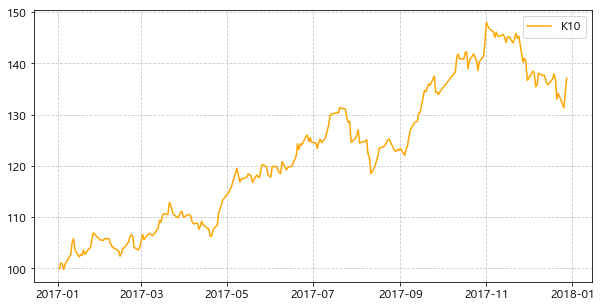

In [19]:
plt.plot(k10['Index'], color='orange', label='K10')
plt.legend(loc=0)
plt.grid(True)

KOSPI200과 비교

In [20]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   # start_date가 있으면
        start_date = date_format(start_date)   # date 포맷으로 변환
    else:    # 없으면
        start_date = dt.date.today()   # 오늘 날짜를 지정
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()   # 지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')   # 뷰티풀 스프로 태그별로 코드 분류
    
    dates = source.find_all('td', class_='date')   # <td class="date">태그에서 날짜 수집   
    prices = source.find_all('td', class_='number_1')   # <td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # prices 중 종가지수인 0,4,8,...번째 데이터 추출
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]   # & 뒤의 page=506 부분 추출
        last_page = last_page.split('=')[1]   # = 뒤의 페이지번호만 추출
        last_page = int(last_page)   # 숫자형 변수로 변환
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices  

In [21]:
index_cd = 'KPI200'
historical_prices = dict()
kospi200 = historical_index_naver(index_cd, '2017-1-1', '2017-12-31')
k200 = pd.DataFrame({'Index' : kospi200})
k200.head(3)

,Index
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


In [22]:
# 비교를 편하게 하기 위해 K10 지수를 KOSPI200과 맞춤 (기준일자 기준으로)
k10['Adj Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * k200['Index'][base_date]
k10.head(3)

,Market Cap,Index,Adj Index
2017-01-02,3.053764e+14,100.000000,260.360000
2017-01-03,3.087117e+14,101.092200,263.203652
2017-01-04,3.081785e+14,100.917572,262.748990


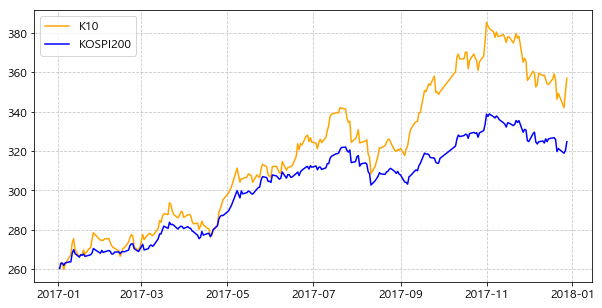

In [23]:
plt.plot(k10['Adj Index'], color='orange', label='K10')
plt.plot(k200['Index'], color='blue', label='KOSPI200')
plt.legend(loc=0)
plt.grid(True)

# Fund 운용

In [24]:
import numpy as np

In [25]:
CU = 50000     # 설정/환매 단위
base_date = dt.date(2017, 1, 2)     # 설정 기준일
volume = 1000000     # 최초 설정수량
interest_rate = 0.02     # 이자율

In [26]:
def creation_redemption(v):
    creation = np.random.randint(0, 5) * CU
    if v>500000:
        redemption = np.random.randint(0, 5) * CU
    else:
        redemption = 0
    volume = v + creation - redemption
    return(creation, redemption, volume)

In [27]:
# 보유비중 산정
k10_stock_ratio = pd.DataFrame()
for s in k10_info.index:
    k10_stock_ratio[s] = k10_historical_mc[s] / k10_historical_mc.sum(axis=1) 

In [28]:
Fund_NAV = pd.DataFrame()
Fund_Chg = pd.DataFrame()

for d in k10_historical_price.index:
    
    # 포트폴리오 구성용 정보 (당일 주가 / 자산비중)
    stock_price = np.array(k10_historical_price.loc[d])
    stock_weight = np.array(k10_stock_ratio.loc[d])
    
    # 기존 주식 포트폴리오 NAV 계산
    if (d <= base_date):     # 기준일 이전
        # 최초 주식 포트폴리오 (보유량 0)
        stock_holdings = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        NAV_cash = 0     # 최초 현금 보유량
    else:     # 기준일 이후
        NAV_stock = sum(stock_holdings * stock_price)     # 주식 잔고
        NAV = NAV_stock + NAV_cash     # 전체 잔고
        
    # 기준가격 산정
    if (d <= base_date):
        # 최초 기준가를 기준일자의 KOSPI 200 지수와 맞춤
        price = k200['Index'][base_date] * 100
    else:
        price = NAV / volume
        
    # 신규 펀드 설정/환매 좌수 계산
    if (d == base_date):
        volume = 0     # 펀드 좌수
        volume_chg = 1000000     # 첫날 설정액
    else:
        vol = creation_redemption(volume)     # 설정/환매 함수 호출
        volume_chg = vol[0] - vol[1]     # 좌수 변동 
    # 총 펀드 좌수에 반영
    volume = volume + volume_chg
    # 펀드 입출금액
    aum_chg = price * volume_chg
    
    # 신규 주식 거래량 계산
    stock_trade = np.floor( price * volume_chg * stock_weight / stock_price )    
    # 주식 매매금액
    trade_amt = sum(stock_trade * stock_price)
    # 현금 잔고 변동 
    cash_chg = aum_chg - trade_amt
    
    # 총 주식 보유량 = 기 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    # 현금 보유량 증가 (이자율 반영)
    cash_holdings = np.floor( NAV_cash * np.exp(interest_rate/365) ) 

    # NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price)     # 주식 잔고
    NAV_cash = cash_holdings + cash_chg     # 현금 잔고
    NAV = NAV_stock + NAV_cash     # 전체 잔고

    date = pd.Series(d)
    
    # Fund NAV 정보를 DataFrame에 저장
    NAV_tmp = {'Stock' : NAV_stock, 'Cash' : NAV_cash, 'Total' : NAV, 'Price' : price}
    tmp = pd.DataFrame(NAV_tmp, index=date)
    Fund_NAV = Fund_NAV.append(tmp)
    
    # 일자별 설정&환매 좌수 정보를 DataFrame에 저장
    Chg_tmp = {'Amount Change' : aum_chg, 'Trade Amount' : trade_amt, 'Cash Change' : cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index=date)
    Fund_Chg = Fund_Chg.append(tmp)

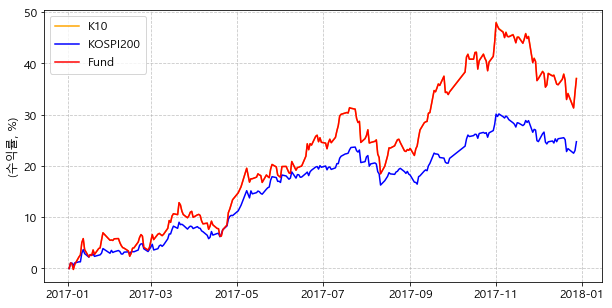

In [29]:
# 펀드 수익률 vs 지수 수익률
Earnings = pd.DataFrame()
Earnings['K10'] = ( k10['Index'] - k10['Index'][base_date] ) / k10['Index'][base_date] * 100
Earnings['KOSPI200'] = ( k200['Index'] - k200['Index'][base_date] ) / k200['Index'][base_date] * 100
Earnings['Fund'] = ( Fund_NAV['Price'] - Fund_NAV['Price'][base_date] )/ Fund_NAV['Price'][base_date] * 100
ax = Earnings.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

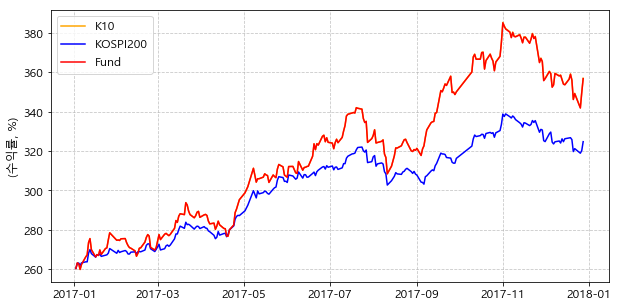

In [30]:
# 펀드 기준가 vs 지수 
Indicator = pd.DataFrame()
Indicator['K10'] = k10['Adj Index']
Indicator['KOSPI200'] = k200['Index']
Indicator['Fund'] = Fund_NAV['Price']/100
ax = Indicator.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

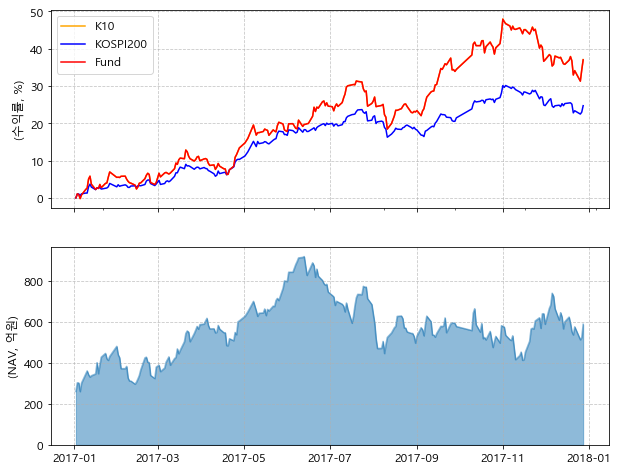

In [31]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
Earnings.plot.line(ax=ax1, color = ['orange', 'b', 'r'])
ax1.set_ylabel('(수익률, %)')
Fund_NAV['Display'] = Fund_NAV['Total'] * 0.00000001
Fund_NAV['Display'].plot.area(ax=ax2, stacked=False, sharex=True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)
ax2.grid(True)

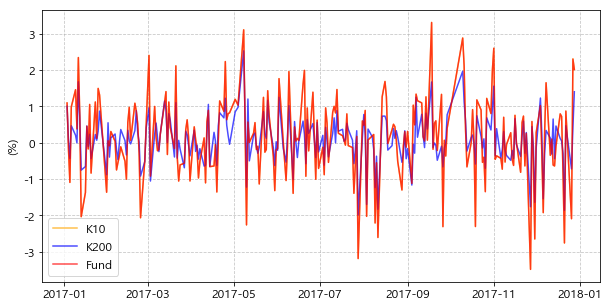

In [32]:
# 일간 수익률
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily = pd.DataFrame()
Daily['K10'] = (k10['Index'] - k10['Index'].shift(1))\
                / k10['Index'].shift(1) * 100  
Daily['K200'] = (k200['Index'] - k200['Index'].shift(1))\
                / k200['Index'].shift(1) * 100
Daily['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'].shift(1))\
                / Fund_NAV['Price'].shift(1) * 100  
Daily.plot(ax=ax, color = ['orange', 'blue', 'red'], alpha=0.7)
ax.set_ylabel('(%)')
ax.grid(True)

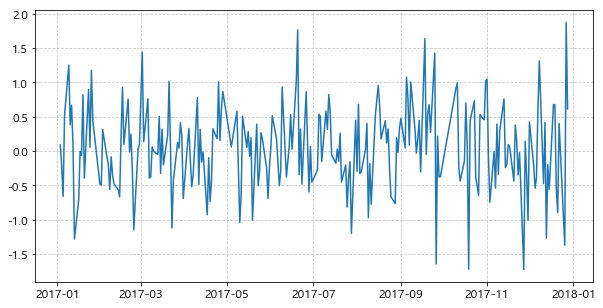

In [33]:
# KOSPI200 대비 일간 추적오차율 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily['TE200'] = Daily['Fund'] - Daily['K200']    # 추적오차율 = 펀드수익률 - 지수수익률
Daily['TE200'].plot(ax=ax)
ax.grid(True)

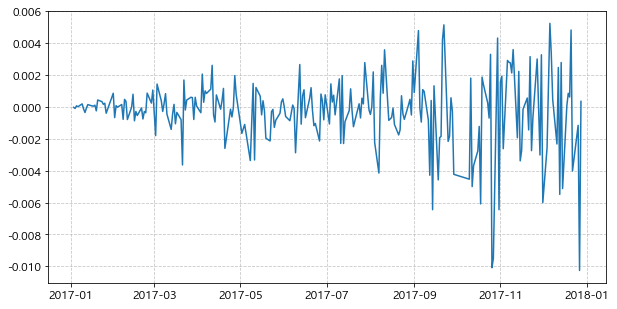

In [34]:
# K10 대비 일간 추적오차율 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
Daily['TE10'] = Daily['Fund'] - Daily['K10']
Daily['TE10'].plot(ax=ax)
ax.grid(True)